<a href="https://colab.research.google.com/github/DietzscheNostoevsky/Learning_Pytorch/blob/main/04_Pytorch_Custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Custom Datasets

- A custom dataset is a collection of data relating to a specific problem we are working on.
- Á custom dataset can be comprised of almost anything.

*PyTorch includes many existing functions to load in various custom datasets in the [`TorchVision`](https://pytorch.org/vision/stable/index.html), [`TorchText`](https://pytorch.org/text/stable/index.html), [`TorchAudio`](https://pytorch.org/audio/stable/index.html) and [`TorchRec`](https://pytorch.org/torchrec/) domain libraries.*

But sometimes these existing functions may not be enough.

In that case, we can always subclass `torch.utils.data.Dataset` and customize it to our liking.

# Notebook Workflow 


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-food-vision-layout.png" alt="building a pipeline to load in food images and then building a pytorch model to classify those food images" width=800 />

we're going to be using our own dataset of pizza, steak and sushi images.

The goal will be to load these images and then build a model to train and predict on them.

 We'll use `torchvision.datasets` as well as our own custom Dataset class to load in images of food and then we'll build a PyTorch computer vision model to hopefully be able to classify them


# 0. Setting up devive agnostic code

In [1]:
import torch
from torch import nn 

torch.__version__

'2.0.1+cu118'

In [2]:
# Setting up device agnostic code 

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 1. Getting data 

Using a subset of food images data from Food101 dataset, which contains 101 food classes, each containing 1000 images per class, total 101,000 images. Each class containing 750 train, 250 test images.  

We are using only random 10% images per class, for 3 classes   
    - Pizza  
    - Steak   
    - Sushi   



## Original Data Source 

Original Data Resources :
* Original [Food101 dataset and paper website](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).
* [`torchvision.datasets.Food101`](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) - the version of the data downloaded for this notebook.
* [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) - a notebook used to format the Food101 dataset to use for this notebook.
* [`data/pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) - the zip archive of pizza, steak and sushi images from Food101, created with the notebook linked above.


In [3]:
import requests
import zipfile
from pathlib import Path
from tqdm.auto import tqdm

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    download_url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

    # Get more data for the same classes 
    #download_url = "https://drive.google.com/file/d/15ruMV4CxcxWomYA9igJ8eERLAUFN8R30/view?usp=sharing"
    download_file = data_path / "pizza_steak_sushi.zip"
    
    response = requests.get(download_url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    progress_bar = tqdm(total=total_size, unit='B', unit_scale=True, desc='Downloading')
    
    with open(download_file, "wb") as f:
        for data in response.iter_content(chunk_size=4096):
            f.write(data)
            progress_bar.update(len(data))
    
    progress_bar.close()
    
    # Unzip pizza, steak, sushi data
    unzip_path = data_path / "pizza_steak_sushi.zip"
    extract_path = image_path

    # It doesn't checks if file is actually downloaded or not, so if zip file 
    # is thorowing an error, check if the file is actually being downloaded or not, and 
    # zip is executing only after file is downloaded. 
    
    with zipfile.ZipFile(unzip_path, "r") as zip_ref:
        file_list = zip_ref.namelist()
        progress_bar = tqdm(file_list, desc='Extracting')
        
        for file in progress_bar:
            zip_ref.extract(file, extract_path)
        
    progress_bar.close()

    print("Download and extraction complete!")


Did not find data/pizza_steak_sushi directory, creating one...


Downloading:   0%|          | 0.00/15.7M [00:00<?, ?B/s]

Extracting:   0%|          | 0/308 [00:00<?, ?it/s]

Download and extraction complete!


# 2. Data Prepration

***What Am I trying to solve ?*** 

We have images of pizza, steak and sushi in standard image classification format.

Image classification format contains separate classes of images in seperate directories titled with a particular class name.

For example, all images of `pizza` are contained in the `pizza/` directory.

This format is popular across many different image classification benchmarks, including [ImageNet](https://www.image-net.org/) (of the most popular computer vision benchmark datasets).

The goal will be to **take this data storage structure and turn it into a dataset usable with PyTorch**.

## Setting up directories

In [4]:
# Helper function to see what is inside the directory 
# using os.walk()
import os


def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [6]:
# Setting up training and testing paths 

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Image Visualization

1. Get all of the image paths using [`pathlib.Path.glob()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob) to find all of the files ending in `.jpg`. 
2. Pick a random image path using Python's [`random.choice()`](https://docs.python.org/3/library/random.html#random.choice).
3. Get the image class name using [`pathlib.Path.parent.stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.parent).
4. And since we're working with images, we'll open the random image path using [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open) (PIL stands for Python Image Library).
5. We'll then show the image and print some metadata.


Random image path: data/pizza_steak_sushi/train/pizza/1008844.jpg
Image class: pizza
Image height: 512
Image width: 512


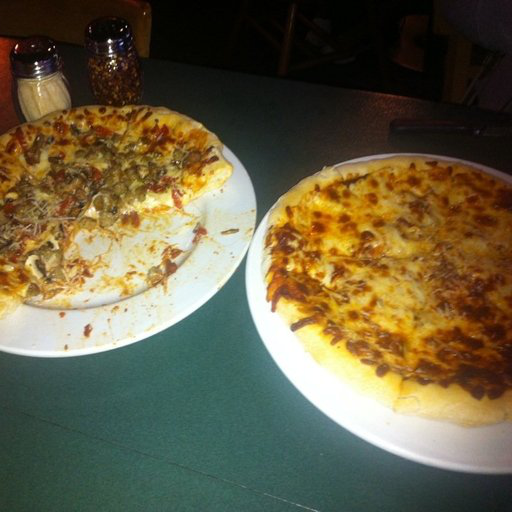

In [7]:
import random
from PIL import Image

random.seed(37)

# Gettting all image paths 
image_path_list = list(image_path.glob("*/*/*.jpg"))

# getting random image path 
random_image_path = random.choice(image_path_list)

# getting image class from path name 

image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

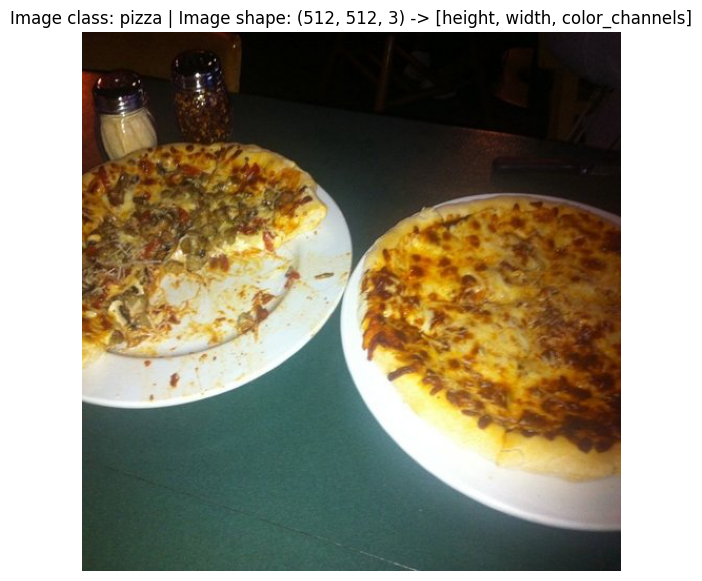

In [8]:
# Using Numpy 
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

# 3. Transforming Data

To load in inside PyTorch

Before we can use our image data with PyTorch we need to:

1. Turn it into tensors (numerical representations of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader` for short.

In [9]:
import torch
from torch.utils.data import DataLoader 
from torchvision import datasets, transforms 

## 3.1 Transforming Data with `torchvision.transforms`

Let's write a series of transform steps that:
1. Resize the images using [`transforms.Resize()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize) (from about 512x512 to 64x64, the same shape as the images on the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/)).
2. Flip our images randomly on the horizontal using [`transforms.RandomHorizontalFlip()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip) (this could be considered a form of data augmentation because it will artificially change our image data).
3. Turn our images from a PIL image to a PyTorch tensor using [`transforms.ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor).

We can compile all of these steps using [`torchvision.transforms.Compose()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose).

In [10]:
# Write transforms for imafge 

data_transform = transforms.Compose([
    #resize the image 
    transforms.Resize(size=(64,64)),
    # flipping images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),# prob of flip 
    # turining image into a torch Tensor 
    transforms.ToTensor()# this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])
data_transform

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)

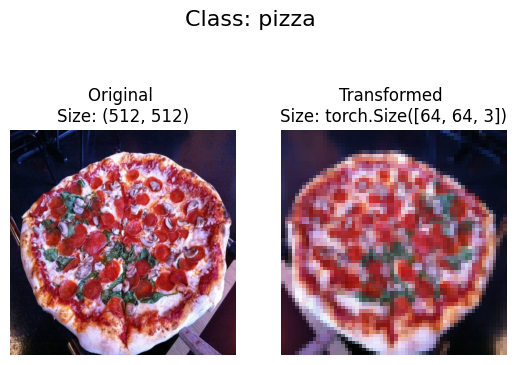

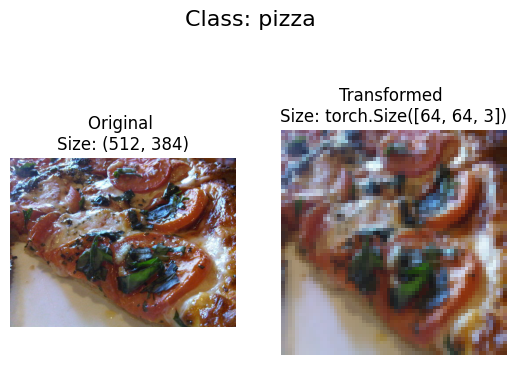

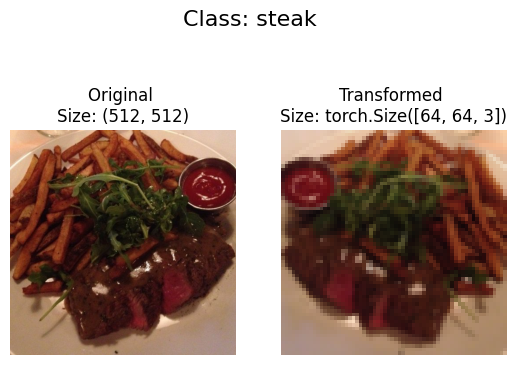

In [11]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths :
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

# 4. Option 1: Loading Image Data Using ImageFolder

Turn our image data into a `Dataset` capable of being used with PyTorch.

Since our data is in standard image classification format, we can use the class [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder).

Where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.

In [12]:
# using ImageFolder to create datasets

from torchvision import datasets

# Similar to this code 
# ---------------------------------------------------------------
#train_data = datasets.FashionMNIST(
#    root="data", # where to download data to?
#    train=True, # get training data
#    download=True, # download data if it doesn't exist on disk
#    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
#    target_transform=None) # you can transform labels as well
# ---------------------------------------------------------------

train_data = datasets.ImageFolder(
    root=train_dir, # target folder of images 
    transform=data_transform, # transforms to perform on data (images)                             
    target_transform=None # transforms to perform on labels (if necessary)
    )
test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform,)
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [13]:
# getting class labels as list 
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [16]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

## Plotting using `matplotlib`

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


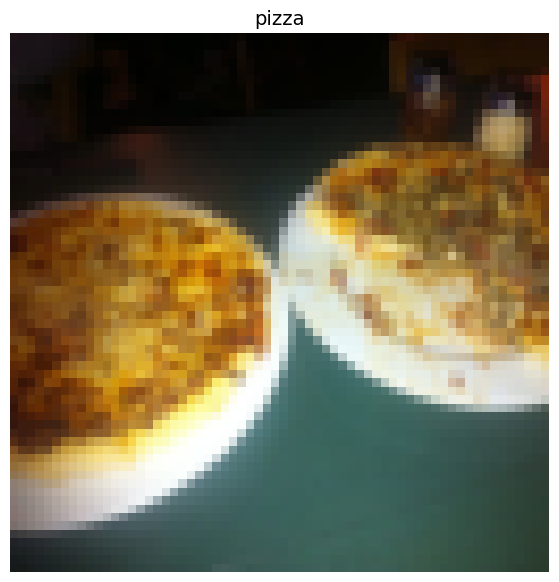

In [17]:
# # Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0) # from CHW to HWC

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

## Turning Loaded images into `DataLoader`

Turning our Dataset's into `DataLoader`'s makes them iterable so a model can go through learn the relationships between samples and targets (features and labels)

In [18]:
os.cpu_count()

2

In [19]:
# turinng train and test Datasets into DataLoaders 

from torch.utils.data import DataLoader
import os
# ----from MNIST example-------------
#
# train_dataloader = DataLoader(train_data, # dataset to turn into iterable
#    batch_size=BATCH_SIZE, # how many samples per batch? 
#   shuffle=True) # shuffle data every epoch?
#
#----------------------------------------

train_dataloader = DataLoader(train_data,
                              batch_size=1, # using a batch size of 1 effectively turns
                                            # the algorithm into Stochastic Gradient Descent (SGD)
                                            # instead of Mini-batch GD
                              num_workers=os.cpu_count(), ## how many subprocesses to use for data loading? (higher = more)
                              shuffle=True
                              )

test_dataloader = DataLoader(test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # no need to shuffle test data

print(F"train_dataloader : {train_dataloader}")
print(F"test_dataloader : {test_dataloader}")

train_dataloader : <torch.utils.data.dataloader.DataLoader object at 0x7f74819568c0>
test_dataloader : <torch.utils.data.dataloader.DataLoader object at 0x7f7481955f00>


In [20]:
# Checing out iterables 

img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# 5. Option 2: Loading Image Data with a Custom `Dataset`

- write code to load your data in the format you'd like it

- Replicating `torchvision.datasets.ImageFolder()` by subclassing `torch.utils.data.Dataset` (the base class for all `Dataset`'s in PyTorch). 


In [21]:
# importing required dependencies 

import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset 
from torchvision import transforms 
from typing import Tuple, Dict, List  


# The line above imports specific type hints from the typing module

# The `typing` module provides built-in types and classes for type annotations
# In this case, Tuple, Dict, and List types are being imported

# These type hints are used to indicate the expected types of function arguments,
# return values, and variables

# Tuple, Dict, and List allow specifying the structure and types of tuples,
# dictionaries, and lists

# For example, Tuple[str, int] indicates a tuple with a string as the first element
# and an integer as the second element

# Similarly, Dict[str, int] represents a dictionary with string keys and integer values

# List[int] represents a list of integers

# Using these type hints improves code readability and enables type checking tools
# to catch potential type errors

In [22]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## Creating helper function to get class names 

1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dictionary of numerical labels, one for each class.

In [23]:
# tewting an example 
# Setup path for target directory 

target_directory = train_dir 
print(F"target directory: {target_directory}")

# get class names from the target directory 

class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])

target directory: data/pizza_steak_sushi/train


In [24]:
a = [entry for entry in list(os.scandir(image_path / "train"))]
print(a)

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]


In [25]:
print(a[1].name)

steak


In [26]:
class_names_found

['pizza', 'steak', 'sushi']

In [27]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [28]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## Create custom `Dataset` to replicate `ImageFolder`


1. Subclass `torch.utils.data.Dataset`.
2. Initialize our subclass with a `targ_dir` parameter (the target data directory) and `transform` parameter (so we have the option to transform our data if needed).
3. Create several attributes for `paths` (the paths of our target images), `transform` (the transforms we might like to use, this can be `None`), `classes` and `class_to_idx` (from our `find_classes()` function).
4. Create a function to load images from file and return them, this could be using `PIL` or [`torchvision.io`](https://pytorch.org/vision/stable/io.html#image) (for input/output of vision data). 
5. Overwrite the `__len__` method of `torch.utils.data.Dataset` to return the number of samples in the `Dataset`, this is recommended but not required. This is so you can call `len(Dataset)`.
6. Overwrite the `__getitem__` method of `torch.utils.data.Dataset` to return a single sample from the `Dataset`, this is required.

In [29]:
# Writing a custom dataset class ( inhereting from torch.utils.data.Dataset )

from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset

class ImageFolderCustom(Dataset):

    # 2. INirializing with a targ_dir and trasnform(optional) parameter : 
    def __init__(self, targ_dir, transform=None) -> None:

        # 3. Create class attributes 
        # get all images paths 

        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # Update this for png or jpeg
        #Setting up transformers
        self.transform = transform
        #create classes and class_to_ind attributes 
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Function to load images 
    def load_image(self, index:int) -> Image.Image:
        """
        Opens an image via a path and returns it
        """
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)

    def __len__(self) -> int:
        "Returns total num of samples"
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label(X, y). "
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]
        
        # Transform in necessary

        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

    



### Creating Transforms

In [30]:
# Augmenting training data

train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

### Testing custom dataset loading class

In [31]:
print(train_dir, "\n", test_dir)

data/pizza_steak_sushi/train 
 data/pizza_steak_sushi/test


In [32]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom


(<__main__.ImageFolderCustom at 0x7f74865fbf10>,
 <__main__.ImageFolderCustom at 0x7f74865f9ea0>)

In [33]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [34]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [35]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [36]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


## creating function to display random images 

Createing a helper function called `display_random_images()` that helps us visualize images in our `Dataset'`s.

Specifically, it'll:
1. Take in a `Dataset` and a number of other parameters such as `classes` (the names of our target classes), the number of images to display (`n`) and a random seed. 
2. To prevent the display getting out of hand, we'll cap `n` at 10 images.
3. Set the random seed for reproducible plots (if `seed` is set). 
4. Get a list of random sample indexes (we can use Python's `random.sample()` for this) to plot.
5. Setup a `matplotlib` plot.
6. Loop through the random sample indexes found in step 4 and plot them with `matplotlib`.
7. Make sure the sample images are of shape `HWC` (height, width, color channels) so we can plot them.

In [37]:
# 1. Take in a Dataset as well as a list of class names

def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed:int = None):
    # 2. Adjust display if n too high
    if n > 10 :
        n = 10
        display_shape = False 
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Settnig random seed 
    if seed:
        random.seed(seed)
    
    # 4. get random sample index: 
    random_samples_idx = random.sample(range(len(dataset)), k=n) # Return a k length list of unique elements
                                                                # chosen from the population sequence. 
                                                                # Used for random sampling without replacement.
    # 5. Setup Plot
    plt.figure(figsize=(16,8))

    # 6. Loop through samples and display random samples 
    from tqdm.auto import tqdm
    for i, targ_sample in tqdm(enumerate(random_samples_idx)):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1,2,0)

        # plot adjusted samples 
        
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

0it [00:00, ?it/s]

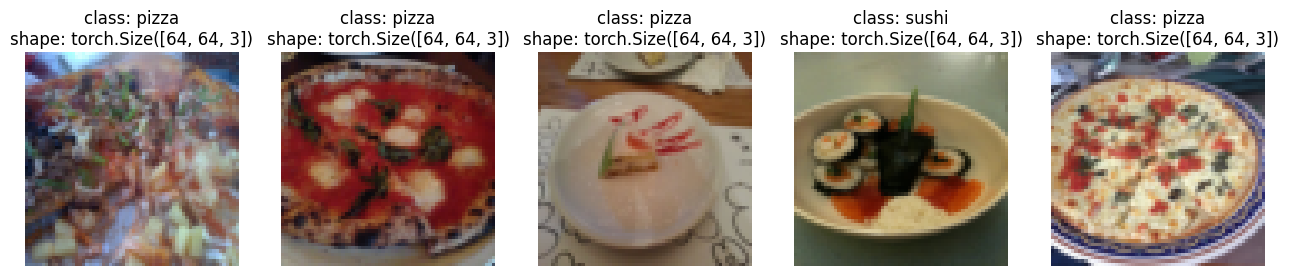

In [38]:
# testing 

display_random_images(train_data,
                      classes=class_names,
                      n=5,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


0it [00:00, ?it/s]

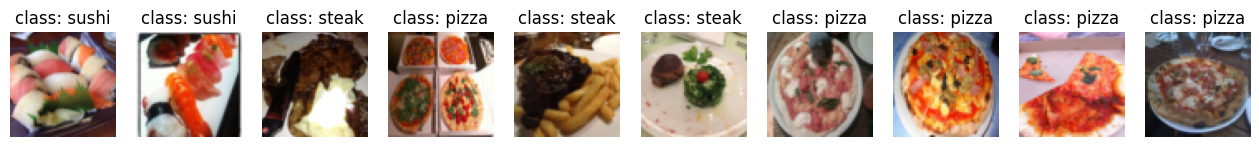

In [39]:
display_random_images(train_data_custom, 
                      n=12, 
                      classes=class_names,
                      seed=None,
                      display_shape=True)

## Turn custom loaded images into `DataLoader`'s

Because our custom `Dataset`'s subclass `torch.utils.data.Dataset`, we can use them directly with `torch.utils.data.DataLoader()`.

And we can do using very similar steps to before except this time we'll be using our custom created `Dataset`'s.

In [40]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f7480d4b4f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f7480d4b580>)

In [41]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# Data Augmentation

Machine learning is all about harnessing the power of randomness and research shows that random transforms (like [`transforms.RandAugment()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#randaugment) and [`transforms.TrivialAugmentWide()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide)) generally perform better than hand-picked transforms.

The idea behind [TrivialAugment](https://arxiv.org/abs/2103.10158) is... well, trivial. 

You have a set of transforms and you randomly pick a number of them to perform on an image and at a random magnitude between a given range (a higher magnitude means more instense).

The main parameter to pay attention to in `transforms.TrivialAugmentWide()` is `num_magnitude_bins=31`.

It defines how much of a range an intensity value will be picked to apply a certain transform, `0` being no range and `31` being maximum range (highest chance for highest intensity). 

We can incorporate `transforms.TrivialAugmentWide()` into `transforms.Compose()`.

Random transforms  
random, which means that the same transfomer instance will produce different result each time it transforms a given image.

In [43]:
from torchvision import transforms 

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data

test_augmentation = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])


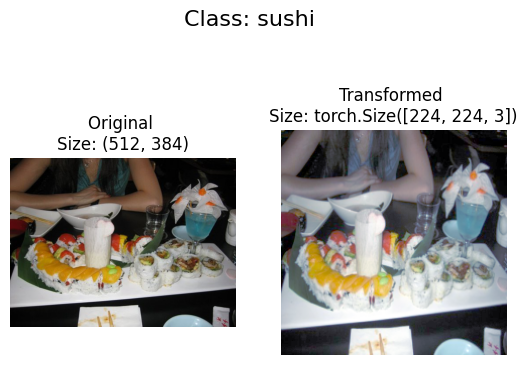

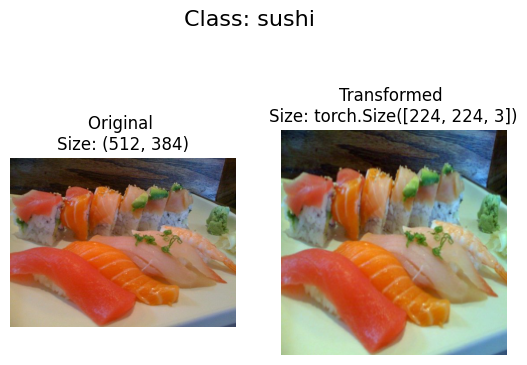

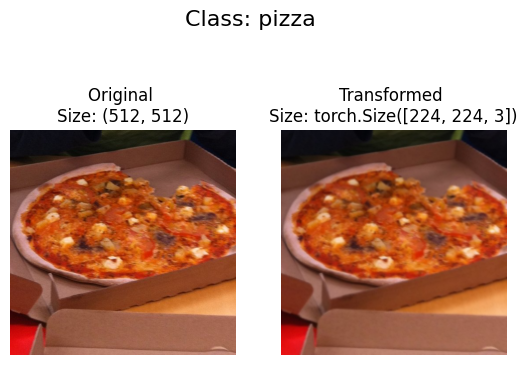

In [45]:
# Testing Augmentation 

image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot Random Images 
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)